<a href="https://colab.research.google.com/github/RosasGabriel/UFPB_ai_exam02/blob/main/AI_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para essa avaliação escolhi como métodos supervisionados a Árvore de Decisão e Naive Nayes e como métodos não supervisionados o K-Médias e o Mean Shift.

Mas antes de poder utilizar esses métodos é necessário fazer todo o pré-processamento do banco de dados utilizados.

Em um primeiro momento tomei a decisão de qual seria meu atributo de saída para que eu pudesse fazer o tratamento necessário nos outros atributos. Analisei os dados presentes e decidi que meu atributo de saída será a raça dos cachorros e vi que o banco apresentava várias colunas que traziam dados categóricos, mas que já tinham vinculadas a elas colunas que faziam a conversão desses dados em valores numérico, logo optei por retirar essas colunas categóricas da minha análise. Outros atributos que optei por retirar foram: temperamento e descrição, pelos seguintes motivos:

->Descrição: é uma tributo bastante complexo e difícil de tratar e considerando os outros atributos já existentes ele poderia não influenciar de forma signifcativa nos modelos utilizados.

->Temperamento: é um atributo bastante semelhante a outro já existente (comportamento).

In [245]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

#Imports para préprocessamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

#Imports para métodos Supervisionados
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

#Imports para métodos Não Supervisionados
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score

dog_db = pd.read_csv('dog_database.csv')

# Prints para checagem de leitura do arquivo
# print(dog_db)
# print(dog_db.head())
# print(dog_db.shape)

ignored_columns = ['description', 'temperament', 'grooming_frequency_category', 'shedding_category', 'energy_level_category', 'trainability_category', 'demeanor_category']

dog_db = dog_db.drop(ignored_columns, axis=1) 
# print(dog_db)
print(dog_db.head())
print(dog_db.shape)

         Unnamed: 0 popularity  min_height  max_height  min_weight  \
0     Affenpinscher        148       22.86       29.21    3.175147   
1      Afghan Hound        113       63.50       68.58   22.679619   
2  Airedale Terrier         60       58.42       58.42   22.679619   
3             Akita         47       60.96       71.12   31.751466   
4  Alaskan Malamute         58       58.42       63.50   34.019428   

   max_weight  min_expectancy  max_expectancy          group  \
0    4.535924            12.0            15.0      Toy Group   
1   27.215542            12.0            15.0    Hound Group   
2   31.751466            11.0            14.0  Terrier Group   
3   58.967008            10.0            13.0  Working Group   
4   38.555351            10.0            14.0  Working Group   

   grooming_frequency_value  shedding_value  energy_level_value  \
0                       0.6             0.6                 0.6   
1                       0.8             0.2                 

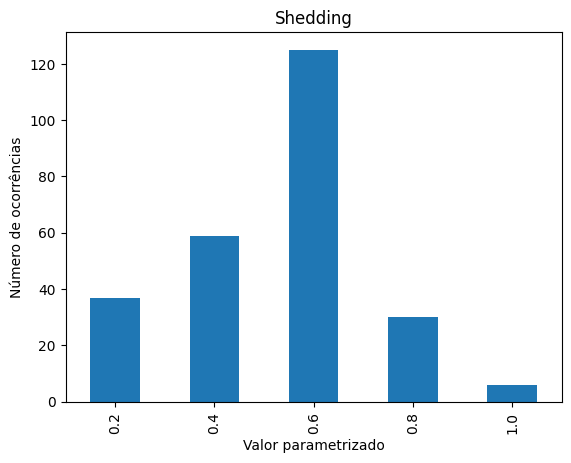

In [246]:
# Teste de organização de plotagem

shedding = dog_db['shedding_value']
count_shedding = shedding.value_counts().sort_index()

count_shedding.plot.bar(x=count_shedding.index)
plt.title("Shedding")
plt.xlabel("Valor parametrizado")
plt.ylabel("Número de ocorrências")
plt.show()

Neste trecho foi onde eu realmente implementei a minha decisão de atributo de saída e comecei a fazer o pré-processamento nos dados que eu realmente iria utilizar.

Como o atributo de saída não possuia um nome, precisei nomeá-lo e o salvei em uma variável.

Em seguida optei por retirar da minha análise todas as raças que possuiam dados incompletos, eu poderia ter preenchido esses dados faltantes com uma média, um mediana ou até buscar os dados individualmente na base oficial da AKC, mas isso poderia acarretar em redução da eficiência dos modelos ou um gasto de tempo considerável, dada a quantidade de dados faltantes. Dessa forma eu acabei perdendo algumas raças que eu poderia classificar mas garatiria mais precisão ao analisar as raças restantes.

Considerando os dados restantes, optei por fazer a codificação inteira no atributo ***group***, transformando dados categóricos em valores numéricos inteiros. Com isso eu teria todos os dados em formato numérico, facilitando desse modo a implementação da normalização em todos os atributos que já não estivessem normalizados.

E por fim, para garantir que houvesse total representatividade dos meus dados durante o treino, ou seja quando eu fosse separar meu banco entre treino e teste eu pudesse garantir que houvesse pelo menos um representante de cada raça durante o treinamento, optei por duplicar os dados existentes após o tratamento.

In [247]:
#Definição do atributo de saída

output_name = 'race'
dog_db = dog_db.rename(columns={dog_db.columns[0]: output_name})
# print(dog_db.columns)

In [248]:
#Retirada de atributos incompletos e codificação inteira

dog_db.dropna(inplace=True)
# print("----------------------------------------------------------------")
# print(dog_db)

int_encoder = LabelEncoder()
dog_db['group_value'] = int_encoder.fit_transform(dog_db['group'])

#Prints de testes para codificação da coluna 'groups'
# print(dog_db.head())
groups_val = int_encoder.classes_
print(groups_val)
uni_val = dog_db['group_value'].unique()
print(uni_val)

#Print para descobrir o valor atribuído a cada classe da coluna 'groups'
# for uni_val, groups_val in zip(dog_db['group_value'], dog_db['group']):
#   print(f'uni_val: {uni_val}, groups_val: {groups_val}')

print('Herding Group = 0\nHound Group = 1\nNon-Sporting Group = 2\nSporting Group = 3\nTerrier Group = 4\nToy Group = 5\nWorking Group = 6')

group_col = 'group'
dog_db = dog_db.drop(group_col, axis=1)
# print(dog_db.head())

['Herding Group' 'Hound Group' 'Non-Sporting Group' 'Sporting Group'
 'Terrier Group' 'Toy Group' 'Working Group']
[5 1 4 6 2 3 0]
Herding Group = 0
Hound Group = 1
Non-Sporting Group = 2
Sporting Group = 3
Terrier Group = 4
Toy Group = 5
Working Group = 6


In [249]:
#Normalização dos atributos

# dog_db['min_weight'] = dog_db['min_weight'].round(2)
# dog_db['max_weight'] = dog_db['max_weight'].round(2)
# print(dog_db.head())

# print(dog_db)

#Teste para descobrir qual coluna possuíam dados tipo 'string' qua não podiam ser tranformadas em float automaticamente pela função normalização
# for col_test in col_normalize:
#   if dog_db[col_test].dtype == object:
#     print(f"Coluna {col_test} contém string")

dog_db['popularity'] = pd.to_numeric(dog_db['popularity'], errors='coerce')

col_normalize = ['popularity', 'min_height', 'max_height', 'min_weight', 'max_weight', 'min_expectancy', 'max_expectancy', 'group_value']
scaler = MinMaxScaler()
dog_db[col_normalize] = scaler.fit_transform(dog_db[col_normalize])


# print(dog_db.head())

In [250]:
#Duplicação direta do banco de dados

double_dog = pd.concat([dog_db, dog_db], ignore_index=True)
#Prints de teste do banco de dados duplicado
# print("<------------------------------ Nova tabela ------------------------------>")
# print(double_dog.head())
# print("<------------------------------ Tamanho da tabela ------------------------------>")
# print(double_dog.shape)

# display(double_dog)

double_dog = double_dog.dropna()
display(double_dog)


,race,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value,group_value
0,Affenpinscher,0.769634,0.16,0.18,0.046667,0.043478,0.800000,0.789474,0.6,0.6,0.6,0.8,1.0,0.833333
1,Afghan Hound,0.586387,0.80,0.80,0.333333,0.260870,0.800000,0.789474,0.8,0.2,0.8,0.2,0.2,0.166667
2,Airedale Terrier,0.308901,0.72,0.64,0.333333,0.304348,0.733333,0.736842,0.6,0.4,0.6,1.0,0.8,0.666667
3,Akita,0.240838,0.76,0.84,0.466667,0.565217,0.666667,0.684211,0.8,0.6,0.8,1.0,0.6,1.000000
4,Alaskan Malamute,0.298429,0.72,0.72,0.500000,0.369565,0.666667,0.736842,0.6,0.6,0.8,0.4,0.8,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,Wire Fox Terrier,0.523560,0.40,0.32,0.100000,0.078261,0.800000,0.789474,0.4,0.2,0.6,0.6,0.6,0.666667
372,Wirehaired Pointing Griffon,0.335079,0.60,0.68,0.233333,0.304348,0.800000,0.789474,0.4,0.6,1.0,0.6,0.6,0.500000
373,Wirehaired Vizsla,0.869110,0.66,0.72,0.300000,0.282609,0.800000,0.736842,0.2,0.6,0.8,0.6,0.6,0.500000
374,Xoloitzcuintli,0.727749,0.20,0.64,0.066667,0.239130,0.866667,0.947368,0.2,0.2,0.8,0.6,0.6,0.333333


<ipython-input-251-18ff2998825d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = double_dog.corr()


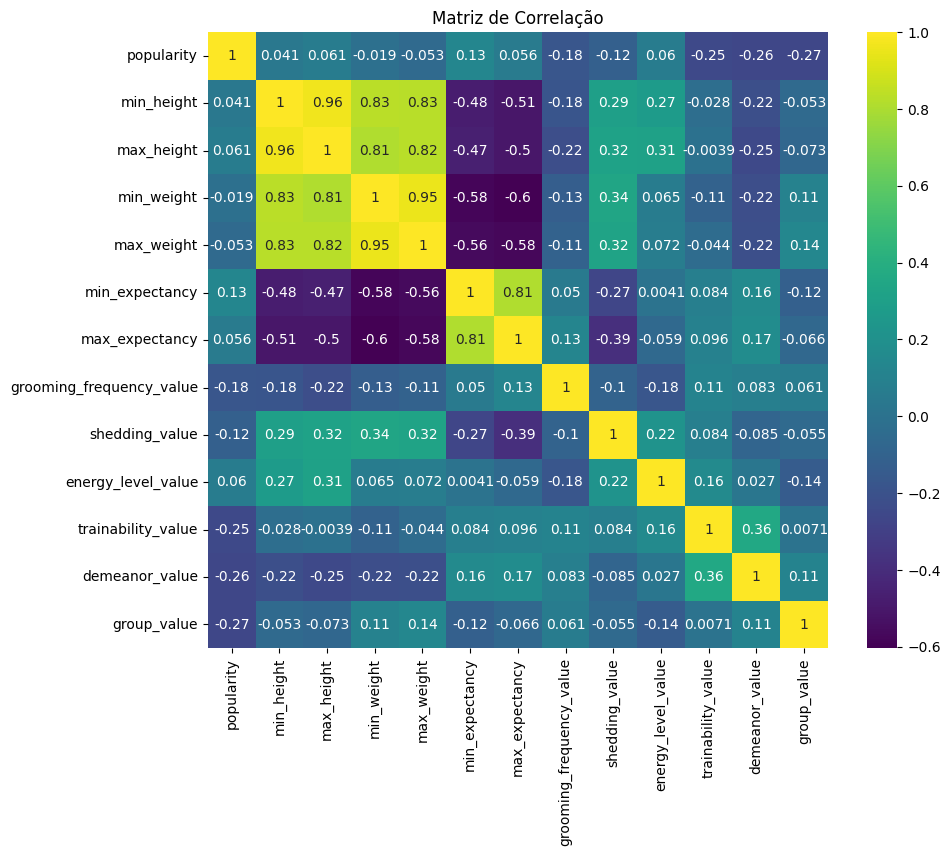

In [251]:
#Plotagem de gráficos relevantes

correlation_matrix = double_dog.corr()

plt.figure(figsize=(10,8))
sb.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Matriz de Correlação')
plt.show()

Para o método da Árvore de Decisão separei os atributos de entrada do atributo de saída e também codifiquei o atributo de saída de valores categóricos para valores numéricos, dessa forma todos os dados ficam padronizados.

A decisão de escolha desse método se dá por sua versatilidade por poder classificar tanto problemas de classificação (que é o caso deste) quanto problemas de regressão, sem contar na sua capacidade de lidar com dados tanto categóricos quanto numéricos.

Como parâmetros de avaliação escolhi três, sendo eles acurácia, precisão e matriz de confusão, pois são métricas simples, de fácil análise e neste caso ajudam a interpretar melhor a eficiência do modelo.

->Acurácia: métrica usada para medir a proporção de acertos em relação total de exemplo do modelo, dado em valores de 0 a 1 pois é valor dado em porcentagem. No caso deste método a acurácia foi de 0.8666666666666667 ou aproximadamente 86,67%, ou seja, do total de 374 casos do banco de dados usado o modelo acertou em torno de 324 casos.

->Precisão: métrica usada para medir a proporção de exemplo positivos que foram classificados corretamente, ou seja, das raças classificadas quantas eram falsos positivos ou não. No caso deste modelo a precisão foi de 0.8693693693693693 ou aproximadamente 86,94%, um valor próximo da acurácia encontrada, com isso podemos interpretar que do total de 374 casos classificados como saída em torno de 48 foram falsos positivos.

E por fim para ajudar nessa análise de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos plotei uma matriz de confusão.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acurácia:  0.8666666666666667
Precisão:  0.8693693693693693


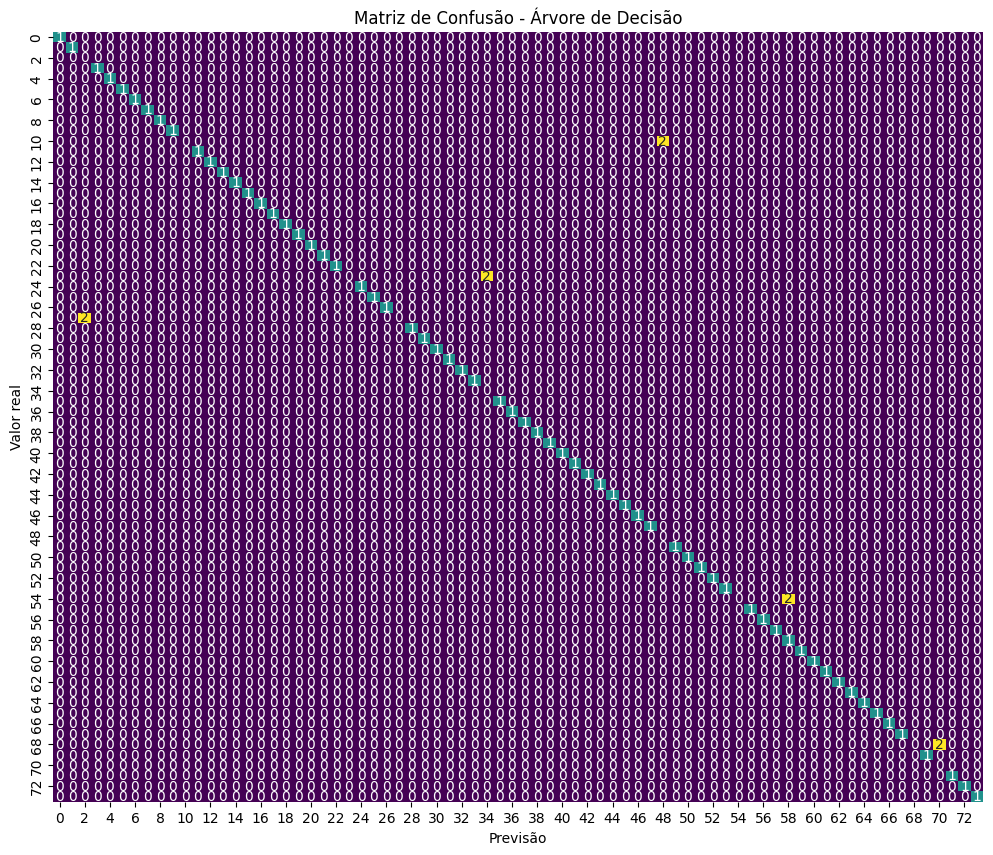

In [252]:
#Implementação da Árvore de Decisão

#Variáveis de entrade e saída dos métodos Supervisionados
output = double_dog['race']
input_sup = double_dog.drop('race', axis=1)

#Codificação do atributo de saída
race_encoder = LabelEncoder()
encoded_output = race_encoder.fit_transform(output)

#Testes para verificar a existência de valores NaN
# nan_indices = np.argwhere(input_sup.isna().values)
# if nan_indices.size > 0:
#     print("Valores NaN encontrados em input_sup:")
#     for index in nan_indices:
#         row, col = index[0], index[1]
#         print(f"Linha {row}, Coluna {col}: {input_sup.iloc[row, col]}")
# else:
#     print("Não foram encontrados valores NaN em input_sup")

#Divisão dos dados em treinamento e teste
#Valor arbitrário da 'seed' definido para 23
out_train, out_test, in_train, in_test = train_test_split(encoded_output, input_sup, test_size=0.2, random_state=23)

#Prints de test para a divisão dos dados de treinamento e teste
# print("Saída de treinamento\n", out_train)
# print("------------------------------------------------")
# print("Entrada de trinamento\n", in_train)
# print("------------------------------------------------")
# print("Saída de teste\n", out_test)
# print("------------------------------------------------")
# print("Entrada de teste\n", in_test)

#Criação e treinamento do modelo de árvore de decisão
model_dt = DecisionTreeClassifier()
model_dt.fit(in_train, out_train)

#Previsão das raças dos cachorros
out_pred_dt = model_dt.predict(in_test)

#Decodificação dos valores previstos
decoded_output = race_encoder.inverse_transform(out_pred_dt)

#Avaliação da acurácia e precisão
accuracy_dt = accuracy_score(out_test, out_pred_dt)
precision_dt = precision_score(out_test, out_pred_dt, average='macro')
print("Acurácia: ", accuracy_dt)
print("Precisão: ", precision_dt)
# print(out_pred_dt)
# print(out_test)
# print("Saída decodificada: ", decoded_output)

#Cálculo da matriz de confusão
cm_dt = confusion_matrix(out_test, out_pred_dt)

#Plot da matrix
plt.figure(figsize=(12, 10))
sb.heatmap(cm_dt, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Valor real')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.show()



Para o método da Naive Bayes utilizei o mesmo conjunto de dados já tratados para o método anterior, como os dados serviam e já haviam sido processados não havia necessidade de retrabalho.

A decisão de escolha desse método se dá pela sua capacidade de lidar com dados categóricos e numéricos assim como a Árvore de Decisão e pela curiosidade de ver qual seria seu comportamento, tendo em vista que o modelo parte do princípio que todos os atributos não possuem correlação, mas a matriz de correlação plotada anteriormente mostra que existem atributos altamente relacionados como peso e altura por exemplo.

Como parâmetros de avaliação escolhi os mesmo três anteriores, pois já ajudaria a comparar os modelos entre si.

->Acurácia: assim como no modelo anterior quero verificar a taxa de acertos totais do modelo. O valor obtido foi de 0.8279569892473119 ou aproximadamente 82,80%.

->Precisão: e de forma análoga ao método anterior decidi ver avaliar a quantidade de falsos positivos resultantes do Naive Bayes. O valor obtido foi de 0.848689138576779 ou aproximandamente 84,87%.

E por fim para ajudar nessa análise de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos plotei uma matriz de confusão. No geral é perceptível que houve uma redução nos valores de ambas as métricas, sendo 3,8% a menos na acurácia e 2% a menos na precisão, minha interpretação é que essa redução da eficiência do método de Naive Bayes está relacionada justamente ao alto nível de correlação de alguns atributos do banco.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acurácia:  0.8279569892473119
Precisão:  0.848689138576779


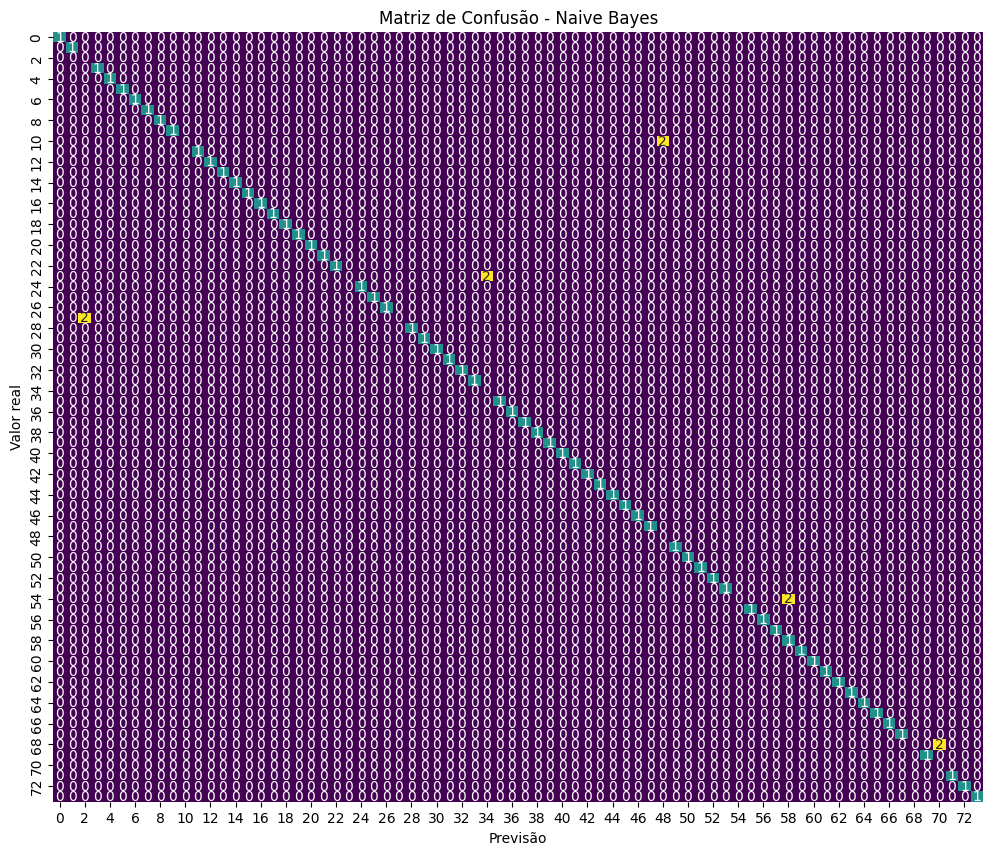

In [253]:
#Implementação de Naive Bayes

#Divisão dos dados em treinamento e teste
#Valor arbitrário da 'seed' definido para 99
out_train, out_test, in_train, in_test = train_test_split(encoded_output, input_sup, test_size=0.25, random_state=99)

#Criação e treinamento do modelo de Naive Bayes
model_nb = GaussianNB()
model_nb.fit(in_train, out_train)

#Previsão das raças dos cachorros
out_pred_nb = model_nb.predict(in_test)

#Decodificação dos valores previstos
decoded_output = race_encoder.inverse_transform(out_pred_nb)

#Avaliação da acurácia e precisão
accuracy_nb = accuracy_score(out_test, out_pred_nb)
precision_nb = precision_score(out_test, out_pred_nb, average='macro')
print("Acurácia: ", accuracy_nb)
print("Precisão: ", precision_nb)
# print(out_pred_nb)
# print(out_test)
# print("Saída decodificada: ", decoded_output)

#Cálculo da matriz de confusão
cm_nb = confusion_matrix(out_test, out_pred_nb)

#Plot da matrix
plt.figure(figsize=(12, 10))
sb.heatmap(cm_dt, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Valor real')
plt.title('Matriz de Confusão - Naive Bayes')
plt.show()

Para o método de K-Médias o uso do banco de dados manteve-se o mesmo, o principal motivo de escolha foi o fato desse método não supervisionado bastante simples e que trabalha com agrupamentos.

A ideia de usar esse método era para ver se esses agrupamentos poderiam refletir o atributo ***groups*** presente no banco de dados.

Como métricas de avaliação optei por usar a curva de inércia, também chamada de cotovelo e o coeficiênte de silhueta:

->Curva de inércia: essa métricas calcula valores baseados nas distâncias entre cada ponto e o centróide dos *clusters* ou grupos, onde para cada valor de K atribuido para esse algoritmo recebe-se um número de grupos que podem ser encontrados. No caso encontrado a curva do gráfico é relativamente suave, entçao considerei o valor de K=8 como o ponto de dobra do cotovelo satisfatório, pois os valores após ele já começavam a alterar menos os número de *clusters*.

->Coeficiente de Silhueta: é uma métrica utilizada para avaliar a qualidade dos grupos obtidos e nos retorna valores que variam de -1 a 1, onde -1 significa que a amostra está próxima de um grupo vizinho do que seu próprio grupo, 0 que as amostras estão no limite de decisão entre o grupos e 1 que as amostrar estão bem ajustadas a seus respectivos grupos. Como neste caso os valores encontrados variavam e 0 a 0.25 significa que as amostras estavam bem próximas do limite de decisão. observação essa que pode ser ajudada pelo gráfico dos grupos..

Neste gráfico é possível observar que para os atributos ***group*** e ***max_height*** por exemplo a divisão entre os grupos não é nítida pois pois cachorros pertencentes a um mesmo grupo podem ter alturas máximas completamente distintas.

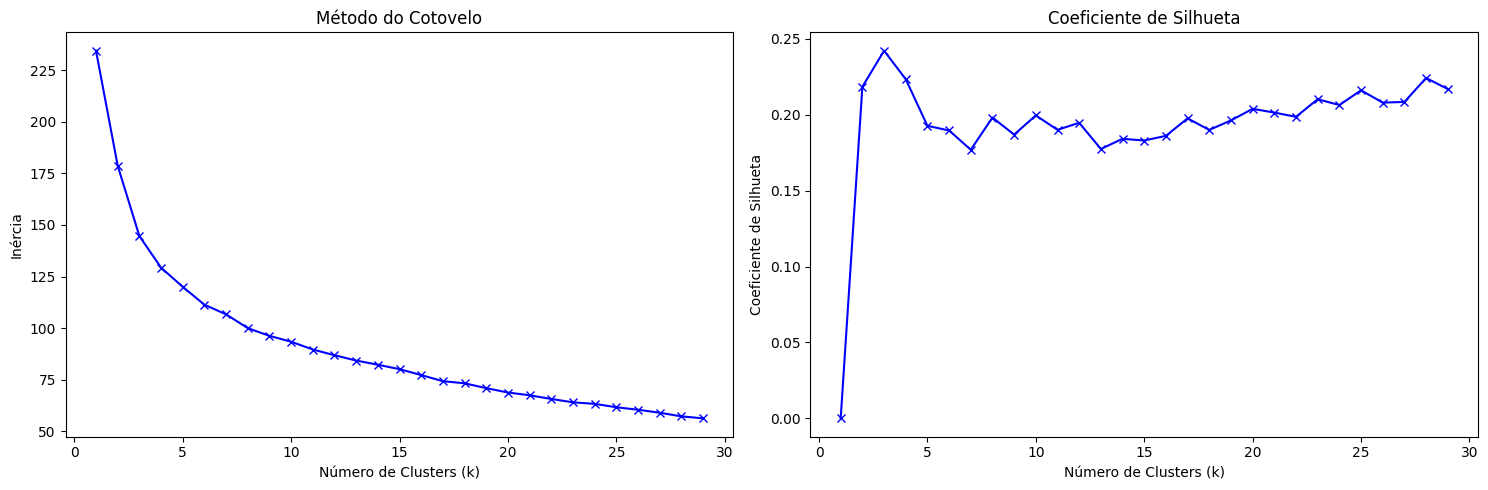

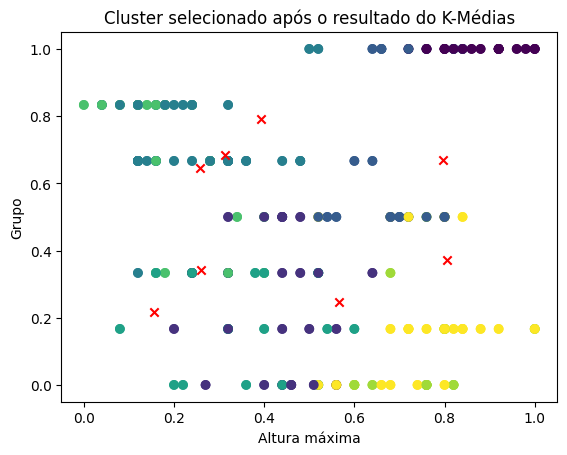

In [254]:
#Implementação de K-Médias (K-Means)

#Variável de entrada usada pela
input_unsup = double_dog.drop('race', axis=1)

#Intervalo de valores de k
k_values = range(1, 30)

#Lista para armazenar as inércias
inertia_km = []
silhouette_km = []

#Execução do K-Means para diferentes valores de k
for k in k_values:
    model_km = KMeans(n_clusters=k, n_init=10)
    model_km.fit(input_unsup)

    inertia_km.append(model_km.inertia_)
    
    #Verificação de erro para o caso de não haver mais de um rótulo
    num_classes = len(np.unique(model_km.labels_))
    if num_classes > 1:
        silhouette_avg = silhouette_score(input_unsup, model_km.labels_)
    else:
        silhouette_avg = 0
    silhouette_km.append(silhouette_avg)

#Plotagem da curva de inércia (cotovelo)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia_km, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')

#Plotagem do coeficiente da silhueta
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_km, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silhueta')
plt.title('Coeficiente de Silhueta')

plt.tight_layout()
plt.show()

#Executar o K-Means com o número de clusters desejado
k = 8  # número de clusters
model_km = KMeans(n_clusters=k, n_init=10)
model_km.fit(input_unsup)

#Obter as labels dos clusters
labels_km = model_km.labels_

#Obter as coordenadas dos centroides dos clusters
centroids = model_km.cluster_centers_

#Plotar os pontos de dados de acordo com os rótulos dos clusters
plt.scatter(input_unsup['max_height'], input_unsup['group_value'], c=labels_km)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red')
plt.xlabel('Altura máxima')
plt.ylabel('Grupo')
plt.title('Cluster selecionado após o resultado do K-Médias')
plt.show()


Para o método de Mean Shift também foi utilizado o mesmo banco de dados tratado, o motivo de sua escolha foi principalmente para fazer um comparativo com o K-Médias, pois os dois são algoritmos de agrupamento mas no caso do Mean Shift ele fará a escolha do valor de K por si só com base nos seus calculos.

Para me aproximar o máximo possível das métricas do K-Médias optei por avaliar o número de grupos encontrados, valor de seu coeficiente de silhueta e fazer um comparativo de seus gráficos de ***Clusters***.

->Número de Clusters: neste caso o algoritmo selecionou o valor de K=2, o que é um resultado inesperado pois ao compararmos com o gráfico do método anterior vemos que para o valor de K=2 a Inércia ainda é alta em relação aos valore seguinte de K.

->Coeficiente de Silhueta: assim como no método anterior o valor do coeficiente manteve um valor próximo a 0.25, neste caso do Mean Shift sendo 0.2778220865446373, significa que o comportamento de amostras estarem próximas do limite de decisão e por conta disso não há uma divisão nítida entre os grupos.

Essa observação fica ainda mais nítida ao avaliar o gráfico de grupos plotado com os mesmo atributos do me´todo não supervisionado anterior.


Número de clusters encontrados: 2
Coeficiente de Silhueta:  0.2778220865446373


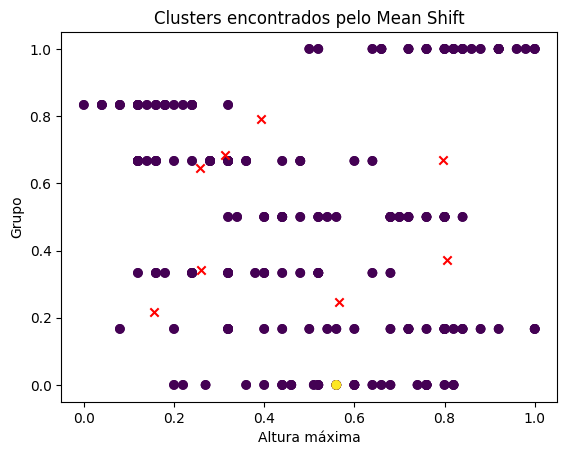

In [255]:
#Implementação de Mean Shift

#Criação do modelo de Mean Shift
model_ms = MeanShift()

#Ajuste dos valores de entrada para o modelo
model_ms.fit(input_unsup)

#Variáveis para obter os rótulos, centróides dos clusters e número de clusters
labels_ms = model_ms.labels_
# centroids = model_ms.cluster_centers_
num_cluster = len(np.unique(labels_ms))

# print("Centróides dos clusters:\n", centroids)
print("\nNúmero de clusters encontrados:", num_cluster)

#Uso do Coeficiente de Silhueta para avaliar o desempenho do método
silhouette = silhouette_score(input_sup, labels_ms)

print("Coeficiente de Silhueta: ", silhouette)

# Plotagem dos clusters encontrados
plt.scatter(input_unsup['max_height'], input_unsup['group_value'], c=labels_ms)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red')
plt.xlabel('Altura máxima')
plt.ylabel('Grupo')
plt.title('Clusters encontrados pelo Mean Shift')
plt.show()